In [ ]:
!nvidia-smi

Mon Sep 13 04:43:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import zipfile
import tensorflow as tf
import cv2
import random
import matplotlib.pyplot as plt
import os
from keras.callbacks import ReduceLROnPlateau
import matplotlib.image as mpimg
from tqdm import tqdm
 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/Cornell-dataset.zip /content/Cornell-dataset.zip
with zipfile.ZipFile('/content/Cornell-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cornell_grasping_dataset/')

In [ ]:
train = np.load('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/train.npy',allow_pickle=True)
test = np.load('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/test1.npy',allow_pickle=True)
 
from sklearn.model_selection import train_test_split
train,_ = train_test_split(train,stratify=train[:,2],test_size=0.8,random_state=4444)
test,_ = train_test_split(test,stratify=test[:,2],test_size=0.60,random_state=4444)
 
len(train),len(test)

(84075, 8744)

In [ ]:
!mkdir /content/tempimages
class Dataset:
    def __init__(self,df):
        self.df = df


    def bboxes_to_grasps(self,box):
        # converting and scaling bounding boxes into grasps, g = {x, y, tan, h, w}
        x = (box[0][0] + (box[2][0] - box[0][0])/2)
        y = (box[0][1] + (box[2][1] - box[0][1])/2)
        tan =(box[2][0] -box[3][0]) / (box[2][1] -box[3][1])
        w = np.sqrt(np.power((box[1][0] - box[0][0]), 2) + np.power((box[1][1] -box[0][1]), 2))
        h = np.sqrt(np.power((box[3][0] -box[0][0]), 2) + np.power((box[3][1] -box[0][1]), 2))
        return round(x,3), round(y,3), 360 - (np.rad2deg(np.arctan(round(tan,3) )) + 90), round(h,3), round(w,3)

    # Reverse function
    def grasp_to_bbox_pred(self,x, y, angle, h, w):
        edge1 = (x - w/2, y + h/2)
        edge2 = (x + w/2, y + h/2)
        edge3 = (x + w/2, y - h/2)
        edge4 = (x - w/2, y - h/2)
        a = np.array([edge1, edge2, edge3, edge4])
        a = a - (x,y)
        angle = angle * (3.14/180)
        fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
        a = fun(a)
        a = np.array(a).T
        a = a + (x,y)
        return a

    def __getitem__(self, i):
        if os.path.isfile(f"/content/tempimages/temp{self.df[i][1]}_1.npy") :
            return tf.convert_to_tensor(np.load(f"/content/tempimages/temp{self.df[i][1]}_1.npy")),tf.convert_to_tensor(np.load(f"/content/tempimages/temp{self.df[i][1]}_3.npy"))
        else:
            path = self.df[i][0]
            image=cv2.imread(path)
            box = self.df[i][7]


            # # randome translating image
            height, width = image.shape[:2]
            tt,ttt =  self.df[i][4],self.df[i][5]
            T = np.float32([[1, 0, 50 * tt], [0, 1, 50 * ttt]])
            image = cv2.warpAffine(image, T, (width, height))

            # poin tranlation
            box = box + np.array([50 * tt,50 * ttt])

            # Rotate Image
            angle = self.df[i][6]
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

            # rotate point
            box = box - image_center
            angle = angle * -1
            angle = angle * (3.14/180)
            fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
            box = fun(box)
            box = np.array(box).T
            box = box + image_center
            

            x, y, tan, h, w = self.bboxes_to_grasps(box)

            np.save(f"/content/tempimages/temp{self.df[i][1]}_1.npy",image)
            np.save(f"/content/tempimages/temp{self.df[i][1]}_3.npy",np.round(np.array([x, y, tan, h, w]),2))

            return tf.convert_to_tensor(image),tf.convert_to_tensor(np.round(np.array([x, y, tan, h, w]),2))

    def __len__(self):
        return len(self.df)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(dataset))
 
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [3]:
def efficientnet_load():
    EfficientNet = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False, weights='imagenet',input_shape=(320,320,3), classes=1024)
    for i in range(len(EfficientNet.layers)):
        EfficientNet.layers[i].trainable = False
    return EfficientNet

efficientnet = efficientnet_load()

efficientnet.summary()
tf.keras.utils.plot_model(
    efficientnet, to_file='model.png', show_shapes=True
)

Output hidden; open in https://colab.research.google.com to view.

In [4]:
##Source: https://stackoverflow.com/a/57247833/8211103
from shapely.geometry import Polygon
def calculate_iou(data):
    box_1 = [[data[0],data[1]],[data[2],data[3]],[data[4],data[5]],[data[6],data[7]]]
    box_2 = [[data[8],data[9]],[data[10],data[11]],[data[12],data[13]],[data[14],data[15]]]
 
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = (poly_1.intersection(poly_2).area / poly_1.union(poly_2).area) * 100
    return np.ndarray.astype(np.array(iou),np.float32)
 
def grasp_to_bbox(x1, y1, tan1, h1, w1):
    lst = []
    
    fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
    for i in range(len(x1)):
        x = x1[i]
        y = y1[i]
        tan = tan1[i]
        h = h1[i]
        w = w1[i]
 
 
        angle = tan * (3.14/180)
        edge1 = (x - w/2, y + h/2)
        edge2 = (x + w/2, y + h/2)
        edge3 = (x + w/2, y - h/2)
        edge4 = (x - w/2, y - h/2)
 
        a = np.array([edge1, edge2, edge3, edge4])
        
        a = a - (x,y)
        a = fun(a)
        
        a = np.array(a).T
        
        a = a + (x,y)
        lst.append(a.reshape(1,-1)[0])
    return tf.convert_to_tensor(np.array(lst))
 
def Accuracy(y_train, y_pred):
    # a = tf.square(y_train[:,:2] - y_pred[:,:2])
    # a = tf.sqrt(tf.add(a[:,0], a[:,1]))
    # a = tf.cast(tf.less(a,10),tf.int8)
 
    b = tf.abs(y_train[:,2] - y_pred[:,2])
    b = tf.cast(tf.less(b,30),tf.int8)
    
 
    ## IOU
    f = tf.py_function(grasp_to_bbox,[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4]],Tout=tf.float32)
    f1 = tf.py_function(grasp_to_bbox,[y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3],y_pred[:,4]],Tout=tf.float32)
 
 
    final = tf.concat([f, f1],axis=1)
    fun = lambda x : tf.py_function(calculate_iou,[x],Tout=tf.float32)
    iou = tf.map_fn(fun, final)
    iou = tf.cast(tf.greater(iou,25),tf.int8)
    
 
    # score = tf.reduce_mean(tf.add(tf.add(a,b),iou)/3)
    score = tf.reduce_mean(tf.add(b,iou)/2)
 
    return score
 
def get_model(lr = 0.001):
    input = tf.keras.layers.Input((320,320,3,))
    resnet = efficientnet(input)
    x = tf.keras.layers.Flatten()(resnet)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(5)(x)
    model = tf.keras.models.Model(input,output)
 
    model.compile(tf.keras.optimizers.Adam(lr), loss = 'mse')
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
flatten (Flatten)            (None, 179200)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               91750912  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 109,427,300
Trainable params: 91,753,477
Non-trainable params: 17,673,823
_______________________________________

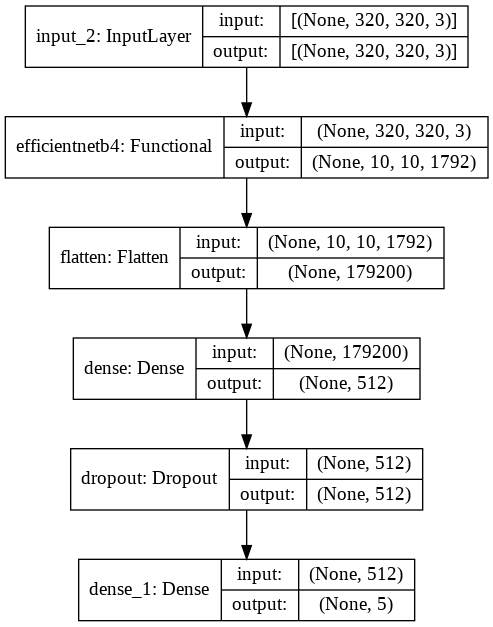

In [5]:
model = get_model()

model.summary()
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True
)

In [ ]:
BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)

In [ ]:
filepath="/content/EfficientNet.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, mode = 'min')
 
model.fit(train_dataloader,epochs=25,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])
!rm /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/CheckPoint/EfficientNet.ckpt
!mv /content/EfficientNet.ckpt /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/CheckPoint/

Epoch 1/25
656/656 [==============================] - 1429s 2s/step - loss: 1200.9633 - val_loss: 655.3062

Epoch 00001: val_loss improved from inf to 655.30621, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
656/656 [==============================] - 1217s 2s/step - loss: 801.3604 - val_loss: 578.0333

Epoch 00002: val_loss improved from 655.30621 to 578.03333, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/25
656/656 [==============================] - 1217s 2s/step - loss: 713.3688 - val_loss: 533.5259

Epoch 00003: val_loss improved from 578.03333 to 533.52588, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/25
656/656 [==============================] - 1219s 2s/step - loss: 660.5908 - val_loss: 491.5955

Epoch 00004: val_loss improved from 533.52588 to 491.59546, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/25
656/656 [==============================] - 1217s 2s/step - loss: 625.4092 - val_loss: 484.2223

Epoch 00005: val_loss improved from 491.59546 to 484.22232, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/25
656/656 [==============================] - 1219s 2s/step - loss: 598.1564 - val_loss: 444.1772

Epoch 00006: val_loss improved from 484.22232 to 444.17722, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/25
656/656 [==============================] - 1220s 2s/step - loss: 576.7431 - val_loss: 429.2302

Epoch 00007: val_loss improved from 444.17722 to 429.23022, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/25
656/656 [==============================] - 1216s 2s/step - loss: 559.0218 - val_loss: 430.3860

Epoch 00008: val_loss did not improve from 429.23022
Epoch 9/25
656/656 [==============================] - 1218s 2s/step - loss: 544.8234 - val_loss: 412.4510

Epoch 00009: val_loss improved from 429.23022 to 412.45105, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/25
656/656 [==============================] - 1220s 2s/step - loss: 524.7112 - val_loss: 387.7723

Epoch 00010: val_loss improved from 412.45105 to 387.77231, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/25
656/656 [==============================] - 1224s 2s/step - loss: 518.1175 - val_loss: 387.5415

Epoch 00011: val_loss improved from 387.77231 to 387.54153, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/25
656/656 [==============================] - 1221s 2s/step - loss: 502.0779 - val_loss: 368.5933

Epoch 00012: val_loss improved from 387.54153 to 368.59329, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/25
656/656 [==============================] - 1225s 2s/step - loss: 491.9122 - val_loss: 368.8763

Epoch 00013: val_loss did not improve from 368.59329
Epoch 14/25
656/656 [==============================] - 1222s 2s/step - loss: 480.7878 - val_loss: 365.1885

Epoch 00014: val_loss improved from 368.59329 to 365.18848, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/25
656/656 [==============================] - 1216s 2s/step - loss: 480.4624 - val_loss: 392.2732

Epoch 00015: val_loss did not improve from 365.18848
Epoch 16/25
656/656 [==============================] - 1216s 2s/step - loss: 470.2152 - val_loss: 352.9094

Epoch 00016: val_loss improved from 365.18848 to 352.90936, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/25
656/656 [==============================] - 1226s 2s/step - loss: 464.5889 - val_loss: 354.4269

Epoch 00017: val_loss did not improve from 352.90936
Epoch 18/25
656/656 [==============================] - 1224s 2s/step - loss: 457.4345 - val_loss: 338.6746

Epoch 00018: val_loss improved from 352.90936 to 338.67459, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/25
656/656 [==============================] - 1223s 2s/step - loss: 446.0763 - val_loss: 328.3419

Epoch 00019: val_loss improved from 338.67459 to 328.34186, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/25
656/656 [==============================] - 1221s 2s/step - loss: 439.6259 - val_loss: 381.2399

Epoch 00020: val_loss did not improve from 328.34186
Epoch 21/25
656/656 [==============================] - 1217s 2s/step - loss: 436.3639 - val_loss: 355.4623

Epoch 00021: val_loss did not improve from 328.34186
Epoch 22/25
656/656 [==============================] - 1215s 2s/step - loss: 428.3528 - val_loss: 339.4199

Epoch 00022: val_loss did not improve from 328.34186

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 23/25
656/656 [==============================] - 1216s 2s/step - loss: 361.6386 - val_loss: 283.8886

Epoch 00023: val_loss improved from 328.34186 to 283.88861, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/25
656/656 [==============================] - 1226s 2s/step - loss: 349.7287 - val_loss: 287.0322

Epoch 00024: val_loss did not improve from 283.88861
Epoch 25/25
656/656 [==============================] - 1217s 2s/step - loss: 339.8309 - val_loss: 271.0811

Epoch 00025: val_loss improved from 283.88861 to 271.08109, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


rm: cannot remove '/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/EfficientNet.ckpt': Is a directory
mv: inter-device move failed: '/content/EfficientNet.ckpt' to '/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/EfficientNet.ckpt'; unable to remove target: Directory not empty


In [ ]:
model = get_model(0.00020000000949949026)
model.load_weights('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/EfficientNet.ckpt')

filepath="/content/EfficientNet.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, mode = 'min')
 
model.fit(train_dataloader,epochs=30,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/30
656/656 [==============================] - 1084s 2s/step - loss: 339.0508 - val_loss: 275.9399

Epoch 00001: val_loss improved from inf to 275.93994, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
656/656 [==============================] - 865s 1s/step - loss: 335.4519 - val_loss: 278.1609

Epoch 00002: val_loss did not improve from 275.93994
Epoch 3/30
656/656 [==============================] - 861s 1s/step - loss: 333.6412 - val_loss: 272.5033

Epoch 00003: val_loss improved from 275.93994 to 272.50333, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/30
656/656 [==============================] - 866s 1s/step - loss: 330.6187 - val_loss: 270.4257

Epoch 00004: val_loss improved from 272.50333 to 270.42566, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/30
656/656 [==============================] - 863s 1s/step - loss: 328.5579 - val_loss: 268.0558

Epoch 00005: val_loss improved from 270.42566 to 268.05585, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/30
656/656 [==============================] - 865s 1s/step - loss: 322.9097 - val_loss: 268.2971

Epoch 00006: val_loss did not improve from 268.05585
Epoch 7/30
656/656 [==============================] - 861s 1s/step - loss: 322.4832 - val_loss: 266.2262

Epoch 00007: val_loss improved from 268.05585 to 266.22620, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/30
656/656 [==============================] - 867s 1s/step - loss: 323.5977 - val_loss: 264.3972

Epoch 00008: val_loss improved from 266.22620 to 264.39725, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/30
656/656 [==============================] - 873s 1s/step - loss: 321.5924 - val_loss: 264.4783

Epoch 00009: val_loss did not improve from 264.39725
Epoch 10/30
656/656 [==============================] - 860s 1s/step - loss: 318.5955 - val_loss: 262.3033

Epoch 00010: val_loss improved from 264.39725 to 262.30328, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/30
656/656 [==============================] - 867s 1s/step - loss: 316.4870 - val_loss: 259.5954

Epoch 00011: val_loss improved from 262.30328 to 259.59543, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/30
656/656 [==============================] - 869s 1s/step - loss: 313.4510 - val_loss: 258.2464

Epoch 00012: val_loss improved from 259.59543 to 258.24643, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/30
656/656 [==============================] - 866s 1s/step - loss: 310.3304 - val_loss: 261.9249

Epoch 00013: val_loss did not improve from 258.24643
Epoch 14/30
656/656 [==============================] - 862s 1s/step - loss: 311.0796 - val_loss: 260.8704

Epoch 00014: val_loss did not improve from 258.24643
Epoch 15/30
656/656 [==============================] - 860s 1s/step - loss: 308.7999 - val_loss: 256.6927

Epoch 00015: val_loss improved from 258.24643 to 256.69266, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/30
656/656 [==============================] - 864s 1s/step - loss: 311.1916 - val_loss: 255.9486

Epoch 00016: val_loss improved from 256.69266 to 255.94864, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/30
656/656 [==============================] - 869s 1s/step - loss: 307.6026 - val_loss: 261.2610

Epoch 00017: val_loss did not improve from 255.94864
Epoch 18/30
656/656 [==============================] - 861s 1s/step - loss: 305.2025 - val_loss: 257.4213

Epoch 00018: val_loss did not improve from 255.94864
Epoch 19/30
656/656 [==============================] - 862s 1s/step - loss: 303.6412 - val_loss: 252.8829

Epoch 00019: val_loss improved from 255.94864 to 252.88295, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/30
656/656 [==============================] - 866s 1s/step - loss: 302.3876 - val_loss: 254.0042

Epoch 00020: val_loss did not improve from 252.88295
Epoch 21/30
656/656 [==============================] - 862s 1s/step - loss: 302.2398 - val_loss: 253.8292

Epoch 00021: val_loss did not improve from 252.88295
Epoch 22/30
656/656 [==============================] - 863s 1s/step - loss: 300.3683 - val_loss: 253.5022

Epoch 00022: val_loss did not improve from 252.88295

Epoch 00022: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 23/30
656/656 [==============================] - 858s 1s/step - loss: 287.8978 - val_loss: 245.5384

Epoch 00023: val_loss improved from 252.88295 to 245.53838, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/30
656/656 [==============================] - 867s 1s/step - loss: 285.4338 - val_loss: 246.1685

Epoch 00024: val_loss did not improve from 245.53838
Epoch 25/30
656/656 [==============================] - 861s 1s/step - loss: 285.0133 - val_loss: 248.7769

Epoch 00025: val_loss did not improve from 245.53838
Epoch 26/30
656/656 [==============================] - 860s 1s/step - loss: 283.4989 - val_loss: 242.6949

Epoch 00026: val_loss improved from 245.53838 to 242.69495, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/30
656/656 [==============================] - 868s 1s/step - loss: 282.6918 - val_loss: 244.0207

Epoch 00027: val_loss did not improve from 242.69495
Epoch 28/30
656/656 [==============================] - 863s 1s/step - loss: 282.3096 - val_loss: 244.4151

Epoch 00028: val_loss did not improve from 242.69495
Epoch 29/30
656/656 [==============================] - 861s 1s/step - loss: 281.1973 - val_loss: 243.0966

Epoch 00029: val_loss did not improve from 242.69495

Epoch 00029: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 30/30
656/656 [==============================] - 861s 1s/step - loss: 279.5251 - val_loss: 242.2392

Epoch 00030: val_loss improved from 242.69495 to 242.23917, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.fit(train_dataloader,epochs=10,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/10
656/656 [==============================] - 871s 1s/step - loss: 279.8429 - val_loss: 241.0136

Epoch 00001: val_loss improved from 242.23917 to 241.01364, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
656/656 [==============================] - 869s 1s/step - loss: 278.3010 - val_loss: 241.3773

Epoch 00002: val_loss did not improve from 241.01364
Epoch 3/10
656/656 [==============================] - 864s 1s/step - loss: 278.3681 - val_loss: 241.6085

Epoch 00003: val_loss did not improve from 241.01364
Epoch 4/10
656/656 [==============================] - 862s 1s/step - loss: 279.2791 - val_loss: 241.6790

Epoch 00004: val_loss did not improve from 241.01364

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 5/10
656/656 [==============================] - 861s 1s/step - loss: 278.6584 - val_loss: 240.8790

Epoch 00005: val_loss improved from 241.01364 to 240.87900, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/10
656/656 [==============================] - 871s 1s/step - loss: 277.1508 - val_loss: 241.2133

Epoch 00006: val_loss did not improve from 240.87900
Epoch 7/10
656/656 [==============================] - 869s 1s/step - loss: 276.0446 - val_loss: 240.9308

Epoch 00007: val_loss did not improve from 240.87900
Epoch 8/10
656/656 [==============================] - 869s 1s/step - loss: 277.9813 - val_loss: 240.6789

Epoch 00008: val_loss improved from 240.87900 to 240.67891, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/10
656/656 [==============================] - 870s 1s/step - loss: 277.2840 - val_loss: 241.0320

Epoch 00009: val_loss did not improve from 240.67891
Epoch 10/10
656/656 [==============================] - 867s 1s/step - loss: 276.5233 - val_loss: 240.6410

Epoch 00010: val_loss improved from 240.67891 to 240.64099, saving model to /content/EfficientNet.ckpt
INFO:tensorflow:Assets written to: /content/EfficientNet.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!mv /content/EfficientNet.ckpt /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/CheckPoint/

In [ ]:
def calculate_iou(data):
    box_1 = [[data[0],data[1]],[data[2],data[3]],[data[4],data[5]],[data[6],data[7]]]
    box_2 = [[data[8],data[9]],[data[10],data[11]],[data[12],data[13]],[data[14],data[15]]]
 
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = (poly_1.intersection(poly_2).area / poly_1.union(poly_2).area) * 100
    return np.ndarray.astype(np.array(iou),np.float32)

def Accuracy(y_train, y_pred):
    # a = tf.square(y_train[:,:2] - y_pred[:,:2])
    # a = tf.sqrt(tf.add(a[:,0], a[:,1]))
    # a = tf.cast(tf.less(a,10),tf.int8)
 
    b = tf.abs(y_train[:,2] - y_pred[:,2])
    b = tf.cast(tf.less(b,30),tf.int8).numpy().reshape(-1,1)
    
    
    ## IOU
    f = grasp_to_bbox(y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4])
    f1 = grasp_to_bbox(y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3],y_pred[:,4])
 
 
    final = tf.concat([f, f1],axis=1).numpy()
    iou = []
    for row in final:
        if calculate_iou(row) >25:
            iou.append(1)
        else:
            iou.append(0)
    iou = np.array(iou).reshape(-1,1)

    score = np.mean(np.sum(np.concatenate([b,iou],axis = 1),axis = 1)/2)
    return score

def score(train_dataloader):
    score = []
    for i in tqdm(range(len(train_dataloader))):
        y_pred = model.predict(train_dataloader[0][0])
        y_train =  train_dataloader[0][1]
        score.append(Accuracy(y_train, y_pred))
    return np.mean(score)

In [ ]:
score(test_dataloader)

100%|██████████| 68/68 [01:21<00:00,  1.20s/it]


0.83203125

In [ ]:
score(train_dataloader)

100%|██████████| 656/656 [12:34<00:00,  1.15s/it]


0.953125

In [ ]:
def grasp_to_bbox_pred(x, y, angle, h, w):
    edge1 = (x - w/2, y + h/2)
    edge2 = (x + w/2, y + h/2)
    edge3 = (x + w/2, y - h/2)
    edge4 = (x - w/2, y - h/2)
    a = np.array([edge1, edge2, edge3, edge4])
    a = a - (x,y)
    angle = angle * (3.14/180)
    fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
    a = fun(a)
    a = np.array(a).T
    a = a + (x,y)
    return a


for i in range(20):

    test_dataloader.batch_size = 1
    i = random.randint(0,128)
    act = test_dataloader[i][1][0]
    pred = model.predict(test_dataloader[i][0])[0]
    act_image = (test_dataloader[i][0][0])

    
    x, y, tan, h, w = act[0],act[1],act[2],act[3],act[4]
    edges = grasp_to_bbox_pred(x, y, tan, h, w)
    
    x = edges[:,0].reshape(1,-1)[0]
    y = edges[:,1].reshape(1,-1)[0]
    
    x = np.concatenate([x,x[:1]])
    y = np.concatenate([y,y[:1]])
    
    im = act_image
    fig, ax = plt.subplots(figsize = (12,12))
    ax.imshow(im)
    ax.plot(x,y, 'ro-',color = 'green')
    
    
    x, y, tan, h, w = pred[0],pred[1],pred[2],pred[3],pred[4]
    edges = grasp_to_bbox_pred(x, y, tan, h, w)
    
    x = edges[:,0].reshape(1,-1)[0]
    y = edges[:,1].reshape(1,-1)[0]
    
    x = np.concatenate([x,x[:1]])
    y = np.concatenate([y,y[:1]])
    
    
    ax.plot(x,y, 'ro-')
    
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [6]:
model = get_model()
model.load_weights('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/EfficientNet.ckpt')

model.save_weights("/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/Models/EfficientNet.h5")